In [1]:
#Import pacakges
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
%matplotlib inline

In [2]:
#open and load json file with feature selected columns
with open('feats_list.json', 'r') as fp:
    data = json.load(fp)

In [3]:
#Get key names
data.keys()

dict_keys(['filt_cols', 'rf_cols', 'all_cols'])

In [4]:
#create lists of columns for each filter selection method and all_cols
fm_cols = data['filt_cols']
rf_cols = data['rf_cols']
all_cols = data['all_cols']

In [5]:
#Load original data set
df = pd.read_csv('C:\\Users\\pseudo_bounce\\Desktop\\recent_dl\\loan-default-prediction\\train.csv')

C:\Users\pseudo_bounce\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (135,204,274,417) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#Drop mixed data type columns [135,204,274,417]
drop_mix = list(df.columns[[135,204,274,417]])
df.drop(drop_mix,axis=1,inplace=True)

In [7]:
#Create binary variable from target column 'loss'
#drop loss column
df['default'] = df['loss'].apply(lambda x: 1 if x > 0 else x)
df.drop('loss',axis=1,inplace=True)

In [8]:
#create dataframes for all_cols and filter selection methods
filt_cols = df[fm_cols]
rf_cols = df[rf_cols]
all_cols = df[all_cols]

In [9]:
print(f'all_cols df shape is: {all_cols.shape}')
print(f'Filter method df shape is: {filt_cols.shape}')
print(f'Random forest method df shape is: {rf_cols.shape}')

all_cols df shape is: (105471, 751)
Filter method df shape is: (105471, 53)
Random forest method df shape is: (105471, 334)


In [10]:
#import necessary packages
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, auc,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

### Making train/test splits
We need to make 3 different train test splits, one for each feature selection method and one that retains all columns for the PCA pipeline.

In [12]:
#make train/test splits for filter feature selection method df

X_filt_train, X_filt_test, y_filt_train, y_filt_test = train_test_split(filt_cols.drop('default',axis=1),
                                                                        filt_cols['default'],
                                                                        test_size = .20,random_state=11,
                                                                        stratify = filt_cols['default'])

print(X_filt_train.shape)
print(X_filt_test.shape)
print(y_filt_train.shape)
print(y_filt_test.shape)

(84376, 52)
(21095, 52)
(84376,)
(21095,)


In [11]:
#make train/test splits for rf feature selection method df

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(rf_cols.drop('default',axis=1),
                                                                        rf_cols['default'],
                                                                        test_size = .20,random_state=11,
                                                                        stratify = rf_cols['default'])

print(X_rf_train.shape)
print(X_rf_test.shape)
print(y_rf_train.shape)
print(y_rf_test.shape)

(84376, 333)
(21095, 333)
(84376,)
(21095,)


In [14]:
#make train/test splits for entire df for dimension reduction

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(all_cols.drop('default',axis=1),
                                                                        all_cols['default'],
                                                                        test_size = .20,random_state=11,
                                                                        stratify = all_cols['default'])

print(X_all_train.shape)
print(X_all_test.shape)
print(y_all_train.shape)
print(y_all_test.shape)

(84376, 750)
(21095, 750)
(84376,)
(21095,)


### Create pipeline for model
Two pipelines will be created.  One pipeline for the ensemble and filter method features, and another for pass the entire data set through PCA.

In [286]:
# Create a pipeline for selected features
pipes = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                  ("classifier", RandomForestClassifier())])

In [287]:
# Create parameter grid for models and hyperparameters
grid_param = [
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": [100, 10, 1.0, 0.1, 0.01]
                 },
                {"classifier": [AdaBoostClassifier()],
                 "classifier__n_estimators": [50,100,150,200],
                 "classifier__learning_rate": np.arange(0,1,.01)
                 },
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,10,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}]

In [299]:
# create a random_search of the pipeline, to find optimal the best model
random_search_filt = RandomizedSearchCV(pipes, 
                                   param_distributions = grid_param, 
                                   cv=5, 
                                   verbose=0,
                                   n_jobs=-1,
                                   n_iter=25,
                                   scoring='roc_auc')

### Pipeline with filtered feature selection

In [300]:
%%time
#Fit the random search object to the filtered features

best_model_filt = random_search_filt.fit(X_filt_train,y_filt_train)
print(best_model_filt.best_estimator_)
print("The AUC score of the model is:",best_model_filt.score(X_filt_test,y_filt_test))

Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier',
                 AdaBoostClassifier(learning_rate=0.56, n_estimators=200))])
The AUC score of the model is: 0.6687976359532222
Wall time: 22min 8s


In [301]:
#Make class predictions on X_filt_test
y_pred_filt = best_model_filt.best_estimator_.predict(X_filt_test)

#Create classification report and convert to dataframe
best_model_filt_report = classification_report(y_filt_test,y_pred_filt,output_dict=True)
filt_feaures_report = pd.DataFrame(best_model_filt_report).transpose()

In [302]:
filt_feaures_report

,precision,recall,f1-score,support
0,0.907508,0.999739,0.951394,19138.000000
1,0.583333,0.003577,0.007110,1957.000000
accuracy,0.907324,0.907324,0.907324,0.907324
macro avg,0.745421,0.501658,0.479252,21095.000000
weighted avg,0.877434,0.907324,0.863792,21095.000000


In [303]:
#print confusion matrix
confusion_matrix(y_filt_test,y_pred_filt)

array([[19133,     5],
       [ 1950,     7]], dtype=int64)

In [304]:
print("The AUC score of the training data is:",best_model_filt.score(X_filt_train,y_filt_train))
print("The AUC score of the tesing data is:",best_model_filt.score(X_filt_test,y_filt_test))

The AUC score of the training data is: 0.6972954627284522
The AUC score of the tesing data is: 0.6687976359532222


In [305]:
# obtain class probabilities on X_filt_test
y_pred_filt_probs = best_model_filt.best_estimator_.predict_proba(X_filt_test)

In [306]:
filt_preds = y_pred_filt_probs[:,1]

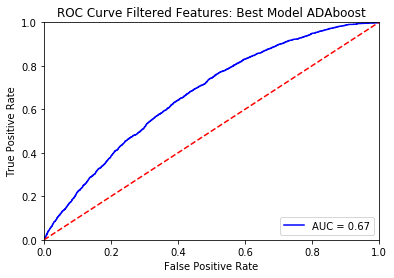

In [307]:
fpr, tpr, threshold = roc_curve(y_filt_test, filt_preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve Filtered Features: Best Model ADAboost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [308]:
scores_filt = pd.DataFrame(best_model_filt.cv_results_)
scores_filt = scores_filt.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_filt

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__learning_rate,param_classifier,param_classifier__min_samples_leaf,param_classifier__max_leaf_nodes,param_classifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,125.330744,0.453082,2.588610,0.030937,200,0.56,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 200, 'classifier_...",0.674219,0.680815,0.677015,0.661082,0.693740,0.677374,0.010537,1
1,88.629118,2.354603,1.751338,0.033743,150,0.46,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 150, 'classifier_...",0.674952,0.679869,0.674788,0.660938,0.693275,0.676765,0.010392,2
2,124.855184,0.671601,2.582983,0.049506,200,0.65,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 200, 'classifier_...",0.673747,0.680396,0.676336,0.659804,0.693210,0.676699,0.010776,3
3,91.416373,1.033403,1.777462,0.137278,150,0.44,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 150, 'classifier_...",0.675508,0.678879,0.674384,0.661392,0.692209,0.676474,0.009861,4
4,126.374106,1.534713,2.577827,0.049487,200,0.71,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 200, 'classifier_...",0.672366,0.680715,0.676109,0.659554,0.693479,0.676445,0.011049,5
5,62.314407,1.631823,1.316936,0.025000,100,0.19,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 100, 'classifier_...",0.672087,0.674974,0.668030,0.659470,0.689554,0.672823,0.009863,6
6,32.234713,0.452717,0.687545,0.013492,50,0.92,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 50, 'classifier__...",0.666901,0.675466,0.668330,0.660653,0.685760,0.671422,0.008578,7
7,63.169675,0.717867,1.269960,0.051950,100,0.12,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 100, 'classifier_...",0.667788,0.668830,0.663368,0.655882,0.685668,0.668307,0.009805,8
8,31.305761,0.745146,0.677913,0.071344,50,0.25,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 50, 'classifier__...",0.667340,0.668831,0.661862,0.655519,0.684568,0.667624,0.009679,9
9,32.093599,0.601151,0.696953,0.038145,50,0.2,"AdaBoostClassifier(learning_rate=0.56, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 50, 'classifier__...",0.664200,0.665775,0.660113,0.653723,0.682097,0.665182,0.009428,10


In [32]:
filt_fi = best_model_filt.best_estimator_.named_steps["classifier"].feature_importances_

In [33]:
df_imp = pd.DataFrame(data=filt_fi,index=X_filt_train.columns).sort_values(by=0,ascending=False)

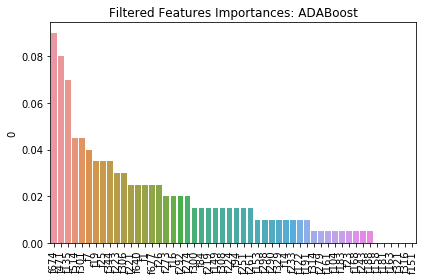

In [34]:
sns.barplot(x=df_imp.index,y=df_imp[0])
plt.title("Filtered Features Importances: ADABoost")
plt.xticks(rotation=90)
plt.tight_layout()

### Pipeline with random forest selected feature

In [309]:
# create a random_search of the pipeline, to find optimal the best model
random_search_rf = RandomizedSearchCV(pipes, 
                                   param_distributions = grid_param, 
                                   cv=5, 
                                   verbose=0,
                                   n_jobs=-1,
                                   n_iter=25,
                                   scoring='roc_auc')

In [310]:
%%time
#Fit the random search object to the random forest selected features
best_model_rf = random_search_rf.fit(X_rf_train,y_rf_train)
print(best_model_rf.best_estimator_)
print("The AUC score of the model is:",best_model_rf.score(X_rf_test,y_rf_test))

Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier',
                 AdaBoostClassifier(learning_rate=0.34, n_estimators=200))])
The AUC score of the model is: 0.6974686665171819
Wall time: 1h 45min


In [312]:
#Make class predictions on X_filt_test
y_pred_rf = best_model_rf.best_estimator_.predict(X_rf_test)

#Create classification report and convert to dataframe
best_model_rf_report = classification_report(y_rf_test,y_pred_rf,output_dict=True)
rf_features_report = pd.DataFrame(best_model_filt_report).transpose()

In [313]:
rf_features_report

,precision,recall,f1-score,support
0,0.907508,0.999739,0.951394,19138.000000
1,0.583333,0.003577,0.007110,1957.000000
accuracy,0.907324,0.907324,0.907324,0.907324
macro avg,0.745421,0.501658,0.479252,21095.000000
weighted avg,0.877434,0.907324,0.863792,21095.000000


In [314]:
#print confusion matrix
confusion_matrix(y_rf_test,y_pred_rf)

array([[19134,     4],
       [ 1948,     9]], dtype=int64)

In [315]:
print("The AUC score of the training data is:",best_model_rf.score(X_rf_train,y_rf_train))
print("The AUC score of the tesing data is:",best_model_rf.score(X_rf_test,y_rf_test))

The AUC score of the training data is: 0.7321046585908434
The AUC score of the tesing data is: 0.6974686665171819


In [316]:
# obtain class probabilities on X_rf_test
y_pred_rf_probs = best_model_rf.best_estimator_.predict_proba(X_rf_test)
rf_preds = y_pred_rf_probs[:,1]

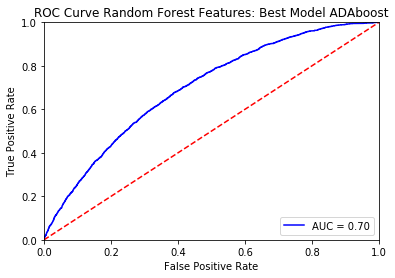

In [317]:
fpr, tpr, threshold = roc_curve(y_rf_test, rf_preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve Random Forest Features: Best Model ADAboost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [343]:
scores_rf = pd.DataFrame(best_model_rf.cv_results_)
scores_rf = scores_rf.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_rf.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__learning_rate,param_classifier,param_classifier__min_samples_leaf,param_classifier__max_leaf_nodes,param_classifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,847.505789,2.460640,7.362910,0.265494,200,0.34,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 200, 'classifier_...",0.703594,0.710097,0.705854,0.689928,0.727699,0.707434,0.012178,1
1,814.084539,4.020694,7.387843,0.110968,200,0.24,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 200, 'classifier_...",0.702492,0.709521,0.703595,0.690237,0.728277,0.706825,0.012424,2
2,636.381698,3.423557,5.653282,0.106722,150,0.3,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 150, 'classifier_...",0.701079,0.707753,0.702431,0.688787,0.725352,0.705081,0.011887,3
3,636.660668,5.383336,5.501488,0.151446,150,0.24,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 150, 'classifier_...",0.700513,0.706232,0.700907,0.688054,0.727094,0.704560,0.012749,4
4,637.860358,8.440795,5.925975,0.243157,150,0.66,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 150, 'classifier_...",0.698775,0.705899,0.703782,0.689241,0.724445,0.704429,0.011540,5
5,641.140371,5.433883,5.264322,0.056198,150,0.23,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 150, 'classifier_...",0.700434,0.705608,0.701113,0.687506,0.726146,0.704161,0.012538,6
6,418.755105,6.178335,3.824174,0.099082,100,0.4,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 100, 'classifier_...",0.698195,0.704596,0.700550,0.687299,0.723686,0.702865,0.011882,7
7,420.246517,4.624500,3.574242,0.174327,100,0.36,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 100, 'classifier_...",0.697633,0.703419,0.700242,0.686392,0.721922,0.701922,0.011530,8
8,557.817007,22.943073,3.303780,0.609244,150,0.79,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 150, 'classifier_...",0.696062,0.704770,0.703196,0.687690,0.717477,0.701839,0.009885,9
9,419.467201,6.622358,3.671780,0.117040,100,0.67,"AdaBoostClassifier(learning_rate=0.34, n_estim...",NaN,NaN,NaN,"{'classifier__n_estimators': 100, 'classifier_...",0.694847,0.703384,0.703598,0.686583,0.718351,0.701353,0.010569,10


In [50]:
rf_fi = best_model_rf.best_estimator_.named_steps["classifier"].feature_importances_

In [51]:
df_rf_fi = pd.DataFrame(data=rf_fi,index=X_rf_train.columns).sort_values(by=0,ascending=False).head(50)

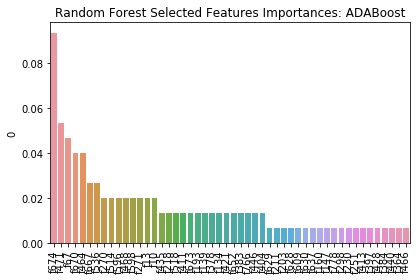

In [52]:
sns.barplot(x=df_rf_fi.index,y=df_rf_fi[0])
plt.title("Random Forest Selected Features Importances: ADABoost")
plt.xticks(rotation=90)
plt.tight_layout()

### Pipeline for dimension reduction on all features
We can continue to use the same paramater grid, however we need to create a new pipeline that has the extra step of scaling the features.  This extra steo is needed and PCA is not robust to unscaled features.

In [327]:
# Create a pipeline for PCA, need to include standard scaler
pipe_pca = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                     ('scaler',StandardScaler()),
                     ('pca',PCA(n_components=175)),
                     ("classifier", RandomForestClassifier())])

In [328]:
# create a random_search of the pipeline, the fit the best model
#Instantiate the randomized search as before only this time using the pca_pipe
random_search_pca = RandomizedSearchCV(pipe_pca, 
                                   param_distributions = grid_param, 
                                   cv=5, 
                                   verbose=0,
                                   n_jobs=-1,
                                   n_iter=25,
                                   scoring='roc_auc')

In [329]:
%%time
#Fit the random search object to the PCA selected features
best_model_pca = random_search_pca.fit(X_all_train,y_all_train)
print(best_model_pca.best_estimator_)
print("The AUC of the model is:",best_model_pca.score(X_all_test,y_all_test))

C:\Users\pseudo_bounce\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=175)),
                ('classifier', LogisticRegression(C=10))])
The AUC of the model is: 0.6992123955886549
Wall time: 1h 22min 23s


In [330]:
#Make class predictions on X_filt_test
y_pred_pca = best_model_pca.best_estimator_.predict(X_all_test)

#Create classification report and convert to dataframe
best_model_pca_report = classification_report(y_all_test,y_pred_pca,output_dict=True)
pca_features_report = pd.DataFrame(best_model_pca_report).transpose()

In [331]:
pca_features_report

,precision,recall,f1-score,support
0,0.907607,0.999373,0.951282,19138.000000
1,0.454545,0.005110,0.010106,1957.000000
accuracy,0.907134,0.907134,0.907134,0.907134
macro avg,0.681076,0.502241,0.480694,21095.000000
weighted avg,0.865576,0.907134,0.863968,21095.000000


In [332]:
#print confusion matrix
confusion_matrix(y_all_test,y_pred_pca)

array([[19126,    12],
       [ 1947,    10]], dtype=int64)

In [333]:
print("The AUC score of the training data is:",best_model_pca.score(X_all_train,y_all_train))
print("The AUC score of the tesing data is:",best_model_pca.score(X_all_test,y_all_test))

The AUC score of the training data is: 0.7188136181410072
The AUC score of the tesing data is: 0.6992123955886549


In [339]:
scores_pca = pd.DataFrame(best_model_pca.cv_results_)
scores_pca = scores_pca.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_pca.loc[10]

mean_fit_time                                                                   742.764
std_fit_time                                                                    11.7537
mean_score_time                                                                 3.40749
std_score_time                                                                 0.195207
param_classifier__n_estimators                                                     1000
param_classifier__learning_rate                                                     NaN
param_classifier                                               RandomForestClassifier()
param_classifier__min_samples_leaf                                                    2
param_classifier__max_leaf_nodes                                                     10
param_classifier__max_depth                                                        None
param_classifier__penalty                                                           NaN
param_classifier__C             

In [64]:
# obtain class probabilities on X_all_test
y_pred_pca_probs = best_model_pca.best_estimator_.predict_proba(X_all_test)
pca_preds = y_pred_pca_probs[:,1]

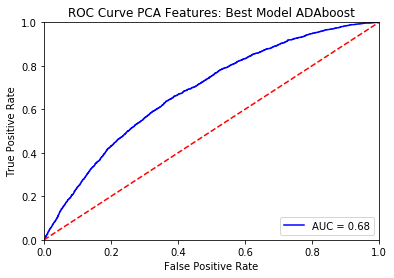

In [65]:
fpr, tpr, threshold = roc_curve(y_all_test, pca_preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve PCA Features: Best Model ADAboost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### XGboost pipelines

In [66]:
 clf = XGBClassifier(objective='binary:logistic')

In [67]:
# Set up parameter grid
param_grid_xgb = [
    { 'n_estimators': [50,100,150,200],
     'learning_rate': [0.01,0.1,0.2,0.3],
     'max_depth': range(3,10),
     'colsample_bytree': [i/10 for i in range(1,3)],
     'gamma': [i/10 for i in range(3)],
     'scale_pos_weight': [8,9,10]
    }]

### XGBoost: Filtered Features

In [68]:
# Instantiate random search with xgb_pipe pipeline
random_search_xgb = RandomizedSearchCV(clf, 
                                   param_distributions = param_grid_xgb, 
                                   cv=5, 
                                   verbose=0,
                                   n_jobs=-1,
                                   n_iter=25,
                                   scoring='roc_auc')

In [72]:
%%time
# Fit filterd features pipeline to random search object
best_model_xgb_filt = random_search_xgb.fit(X_filt_train,y_filt_train)

print(best_model_xgb_filt.best_estimator_)
print("The AUC score of the model is:",best_model_xgb_filt.score(X_filt_test,y_filt_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=9, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
The AUC score of the model is: 0.6700706024975366
Wall time: 5min 38s


In [73]:
# store predictions
y_pred_xgb_filt = best_model_xgb_filt.best_estimator_.predict(X_filt_test)

#get classification report, convert to dataframe
xgb_filt_report = classification_report(y_filt_test,y_pred_xgb_filt,output_dict=True)
report_xgb_filt = pd.DataFrame(xgb_filt_report).transpose()

In [74]:
report_xgb_filt

,precision,recall,f1-score,support
0,0.940066,0.640088,0.761603,19138.000000
1,0.145833,0.600920,0.234707,1957.000000
accuracy,0.636454,0.636454,0.636454,0.636454
macro avg,0.542950,0.620504,0.498155,21095.000000
weighted avg,0.866384,0.636454,0.712722,21095.000000


In [75]:
# Pring confusion matrix
confusion_matrix(y_filt_test,y_pred_xgb_filt)

array([[12250,  6888],
       [  781,  1176]], dtype=int64)

In [76]:
print("The AUC score of the training data is:",best_model_xgb_filt.score(X_filt_train,y_filt_train))
print("The AUC score of the tesing data is:",best_model_xgb_filt.score(X_filt_test,y_filt_test))

The AUC score of the training data is: 0.7341089558444837
The AUC score of the tesing data is: 0.6700706024975366


In [99]:
scores_xbg_filt = pd.DataFrame(best_model_xgb_filt.cv_results_)
scores_xgb_filt = scores_rf.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_xgb_rf.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale_pos_weight,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,188.509983,1.030054,0.622753,0.019628,9,150,4,0.1,0.1,0.2,"{'scale_pos_weight': 9, 'n_estimators': 150, '...",0.716498,0.711527,0.711351,0.698790,0.729464,0.713526,0.009887,1
1,105.497264,1.168407,0.535369,0.005255,8,200,3,0.2,0.1,0.1,"{'scale_pos_weight': 8, 'n_estimators': 200, '...",0.713564,0.707604,0.711671,0.699304,0.721851,0.710799,0.007388,2
2,114.358965,0.590543,0.492883,0.014417,10,100,4,0.1,0.1,0.2,"{'scale_pos_weight': 10, 'n_estimators': 100, ...",0.714065,0.709850,0.707131,0.698354,0.723681,0.710616,0.008315,3
3,88.429908,1.136532,0.470542,0.009740,10,100,3,0.1,0,0.2,"{'scale_pos_weight': 10, 'n_estimators': 100, ...",0.710810,0.709072,0.708178,0.694217,0.726825,0.709821,0.010362,4
4,87.714820,1.182147,0.463162,0.023547,10,100,3,0.3,0.2,0.2,"{'scale_pos_weight': 10, 'n_estimators': 100, ...",0.709511,0.704987,0.701543,0.693202,0.718561,0.705561,0.008412,5
5,92.870442,15.549983,0.459814,0.111425,10,50,6,0.1,0,0.2,"{'scale_pos_weight': 10, 'n_estimators': 50, '...",0.703040,0.703944,0.698986,0.687240,0.716303,0.701903,0.009341,6
6,141.861813,1.716942,0.716884,0.017554,10,150,6,0.1,0,0.1,"{'scale_pos_weight': 10, 'n_estimators': 150, ...",0.699748,0.701320,0.700043,0.688653,0.715011,0.700955,0.008383,7
7,47.493785,0.608058,0.423468,0.012370,9,50,3,0.1,0.2,0.2,"{'scale_pos_weight': 9, 'n_estimators': 50, 'm...",0.699139,0.701258,0.695857,0.683586,0.718433,0.699655,0.011208,8
8,46.709682,0.604802,0.415689,0.007202,8,50,3,0.1,0.2,0.2,"{'scale_pos_weight': 8, 'n_estimators': 50, 'm...",0.698691,0.701878,0.695111,0.683731,0.717964,0.699475,0.011092,9
9,81.531357,1.156946,0.551327,0.013623,9,100,5,0.2,0.1,0.1,"{'scale_pos_weight': 9, 'n_estimators': 100, '...",0.696180,0.695086,0.703620,0.688868,0.711274,0.699006,0.007719,10


In [78]:
# obtain positive class probabilities on X_filt_test
y_pred_xgb_filt_probs = best_model_xgb_filt.best_estimator_.predict_proba(X_filt_test)
xgb_filt_preds = y_pred_xgb_filt_probs[:,1]

(array([1089., 1661., 2281., 3062., 4145., 4623., 3100., 1025.,  103.,
           6.]),
 array([0.00663263, 0.10201042, 0.1973882 , 0.292766  , 0.38814378,
        0.48352158, 0.5788994 , 0.6742772 , 0.7696549 , 0.86503273,
        0.96041054], dtype=float32),
 <a list of 10 Patch objects>)

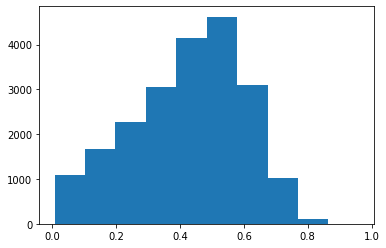

In [79]:
plt.hist(xgb_filt_preds)

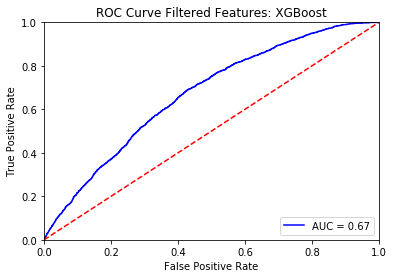

In [80]:
fpr, tpr, threshold = roc_curve(y_filt_test, xgb_filt_preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve Filtered Features: XGBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### XGBoost: Random Forest Features

In [81]:
%%time
# Fit filterd features pipeline to random search object
best_model_xgb_rf = random_search_xgb.fit(X_rf_train,y_rf_train)

print(best_model_xgb_rf.best_estimator_)
print("The AUC score of the model is:",best_model_xgb_rf.score(X_rf_test,y_rf_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=9, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
The AUC score of the model is: 0.7069483176624312
Wall time: 38min 54s


In [82]:
# store predictions
y_pred_xgb_rf = best_model_xgb_rf.best_estimator_.predict(X_rf_test)

#get classification report, convert to dataframe
xgb_rf_report = classification_report(y_rf_test,y_pred_xgb_rf,output_dict=True)
report_xgb_rf = pd.DataFrame(xgb_rf_report).transpose()

In [83]:
report_xgb_rf

,precision,recall,f1-score,support
0,0.944232,0.684763,0.793833,19138.000000
1,0.163941,0.604497,0.257931,1957.000000
accuracy,0.677317,0.677317,0.677317,0.677317
macro avg,0.554087,0.644630,0.525882,21095.000000
weighted avg,0.871844,0.677317,0.744117,21095.000000


In [84]:
# Pring confusion matrix
confusion_matrix(y_rf_test,y_pred_xgb_rf)

array([[13105,  6033],
       [  774,  1183]], dtype=int64)

In [85]:
print("The AUC score of the training data is:",best_model_xgb_rf.score(X_rf_train,y_rf_train))
print("The AUC score of the tesing data is:",best_model_xgb_rf.score(X_rf_test,y_rf_test))

The AUC score of the training data is: 0.8017591431399097
The AUC score of the tesing data is: 0.7069483176624312


In [325]:
scores_xgb_rf = pd.DataFrame(best_model_xgb_rf.cv_results_)
scores_xgb_rf = scores_xgb_rf.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_xgb_rf.loc[0]

NameError: name 'best_model_xgb_rf' is not defined

In [88]:
# obtain positive class probabilities on X_filt_test
y_pred_xgb_rf_probs = best_model_xgb_rf.best_estimator_.predict_proba(X_rf_test)
xgb_rf_preds = y_pred_xgb_rf_probs[:,1]

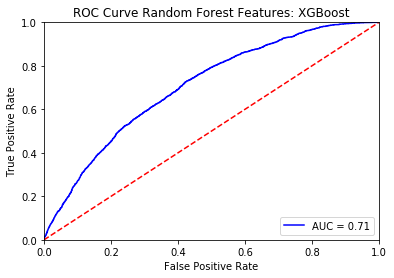

In [89]:
fpr, tpr, threshold = roc_curve(y_rf_test, xgb_rf_preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve Random Forest Features: XGBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### XGboost with PCA Features

In [90]:
# Create a pipeline for PCA, need to include standard scaler
xgb_pipe_pca = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                       ('scaler',StandardScaler()),
                       ('pca',PCA(n_components=175)),
                       ("clf", XGBClassifier(objective='binary:logistic'))])

In [91]:
# Set up parameter grid
param_grid_xgb_pipe = [
    { 'clf__n_estimators': [50,100,150,200],
     'clf__learning_rate': [0.01,0.1,0.2,0.3],
     'clf__max_depth': range(3,10),
     'clf__colsample_bytree': [i/10 for i in range(1,3)],
     'clf__gamma': [i/10 for i in range(3)],
     'clf__scale_pos_weight': [8,9,10]
    }]

In [92]:
# Crate random search object
random_search_xgb_pca = RandomizedSearchCV(xgb_pipe_pca, 
                                   param_distributions = param_grid_xgb_pipe, 
                                   cv=5, 
                                   verbose=0,
                                   n_jobs=-1,
                                   n_iter=25,
                                   scoring='roc_auc')

In [93]:
%%time
# Fit random search object
best_model_xgb_pca = random_search_xgb_pca.fit(X_all_train,y_all_train)
# output best more and PR AUC score
print(best_model_xgb_pca.best_estimator_)
print("The AUC score of the model is:",best_model_xgb_pca.score(X_all_test,y_all_test))

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=175)),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.1, gamma=0.2, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=No

In [94]:
# make predictions
y_pred_xgb_pca = best_model_xgb_pca.best_estimator_.predict(X_all_test)

#get classification report and convert to dataframe
xgb_pca_report = classification_report(y_all_test,y_pred_xgb_pca,output_dict=True)
report_xgb_pca = pd.DataFrame(xgb_pca_report).transpose()

In [95]:
report_xgb_pca

,precision,recall,f1-score,support
0,0.943954,0.642439,0.764543,19138.000000
1,0.152045,0.626980,0.244739,1957.000000
accuracy,0.641005,0.641005,0.641005,0.641005
macro avg,0.547999,0.634710,0.504641,21095.000000
weighted avg,0.870488,0.641005,0.716320,21095.000000


In [96]:
# Print confusion matrix
confusion_matrix(y_all_test,y_pred_xgb_pca)

array([[12295,  6843],
       [  730,  1227]], dtype=int64)

In [97]:
print("The AUC score of the training data is:",best_model_xgb_pca.score(X_all_train,y_all_train))
print("The AUC score of the tesing data is:",best_model_xgb_pca.score(X_all_test,y_all_test))

The AUC score of the training data is: 0.7605141656302169
The AUC score of the tesing data is: 0.6862537502270174


In [100]:
scores_xgb_pca= pd.DataFrame(best_model_xgb_pca.cv_results_)
scores_xgb_pca = scores_rf.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_xgb_pca.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale_pos_weight,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,188.509983,1.030054,0.622753,0.019628,9,150,4,0.1,0.1,0.2,"{'scale_pos_weight': 9, 'n_estimators': 150, '...",0.716498,0.711527,0.711351,0.698790,0.729464,0.713526,0.009887,1
1,105.497264,1.168407,0.535369,0.005255,8,200,3,0.2,0.1,0.1,"{'scale_pos_weight': 8, 'n_estimators': 200, '...",0.713564,0.707604,0.711671,0.699304,0.721851,0.710799,0.007388,2
2,114.358965,0.590543,0.492883,0.014417,10,100,4,0.1,0.1,0.2,"{'scale_pos_weight': 10, 'n_estimators': 100, ...",0.714065,0.709850,0.707131,0.698354,0.723681,0.710616,0.008315,3
3,88.429908,1.136532,0.470542,0.009740,10,100,3,0.1,0,0.2,"{'scale_pos_weight': 10, 'n_estimators': 100, ...",0.710810,0.709072,0.708178,0.694217,0.726825,0.709821,0.010362,4
4,87.714820,1.182147,0.463162,0.023547,10,100,3,0.3,0.2,0.2,"{'scale_pos_weight': 10, 'n_estimators': 100, ...",0.709511,0.704987,0.701543,0.693202,0.718561,0.705561,0.008412,5
5,92.870442,15.549983,0.459814,0.111425,10,50,6,0.1,0,0.2,"{'scale_pos_weight': 10, 'n_estimators': 50, '...",0.703040,0.703944,0.698986,0.687240,0.716303,0.701903,0.009341,6
6,141.861813,1.716942,0.716884,0.017554,10,150,6,0.1,0,0.1,"{'scale_pos_weight': 10, 'n_estimators': 150, ...",0.699748,0.701320,0.700043,0.688653,0.715011,0.700955,0.008383,7
7,47.493785,0.608058,0.423468,0.012370,9,50,3,0.1,0.2,0.2,"{'scale_pos_weight': 9, 'n_estimators': 50, 'm...",0.699139,0.701258,0.695857,0.683586,0.718433,0.699655,0.011208,8
8,46.709682,0.604802,0.415689,0.007202,8,50,3,0.1,0.2,0.2,"{'scale_pos_weight': 8, 'n_estimators': 50, 'm...",0.698691,0.701878,0.695111,0.683731,0.717964,0.699475,0.011092,9
9,81.531357,1.156946,0.551327,0.013623,9,100,5,0.2,0.1,0.1,"{'scale_pos_weight': 9, 'n_estimators': 100, '...",0.696180,0.695086,0.703620,0.688868,0.711274,0.699006,0.007719,10


In [101]:
# obtain positive class probabilities on X_filt_test
y_pred_xgb_pca_probs = best_model_xgb_pca.best_estimator_.predict_proba(X_all_test)
xgb_pca_preds = y_pred_xgb_pca_probs[:,1]

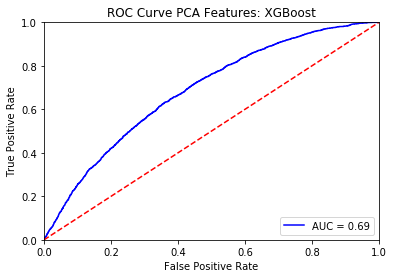

In [102]:
fpr, tpr, threshold = roc_curve(y_all_test, xgb_pca_preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve PCA Features: XGBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Selecting Model for Further Tuning

Thus far 4 separate algorithms were trained on 3 different data sets: logistic regression, random forest, adaboost and xgboost.  The hyper-parameters for each model and dataset are trained via a randomized search with 5 fold cross validation and 25 interations. In each case, the train data scored slightly better than the test data suggesting some overfitting to the training data.  The largest discrepency between train and test scores occurs in the xgboost model when using the random forest selected features, with a train and test score of .801 and .706, respectively.  This configuration also yields the best test and training accuracy, so we select the xgboost model with the random forest features for further tuning.   

In [277]:
 clf_xgb = XGBClassifier(objective='binary:logistic',
                         base_score=0.5, booster='gbtree', colsample_bylevel=.75,
                         colsample_bynode=.3, colsample_bytree=0.2, gamma=0.1, gpu_id=-1,
                         importance_type='gain',
                         learning_rate=0.001, max_delta_step=0, max_depth=4,
                         min_child_weight=15, missing=np.nan, 
                         n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
                         reg_alpha=0, reg_lambda=20, scale_pos_weight=9, subsample=.75,
                         tree_method='exact', validate_parameters=1, verbosity=None,
                                              )

In [278]:
clf_xgb.fit(X_rf_train,y_rf_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
              colsample_bynode=0.3, colsample_bytree=0.2, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=4,
              min_child_weight=15, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=20, scale_pos_weight=9, subsample=0.75,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [279]:
train_preds = clf_xgb.predict(X_rf_train)
test_preds = clf_xgb.predict(X_rf_test)

In [280]:
confusion_matrix(y_rf_train,train_preds)

array([[48628, 27922],
       [ 2935,  4891]], dtype=int64)

In [281]:
confusion_matrix(y_rf_test,test_preds)

array([[12262,  6876],
       [  758,  1199]], dtype=int64)

In [282]:
print("The AUC score of the training data is:",roc_auc_score(y_rf_train,train_preds))
print("The AUC score of the tesing data is:",roc_auc_score(y_rf_test,test_preds))

The AUC score of the training data is: 0.6301064965748332
The AUC score of the tesing data is: 0.6266936330392817


In [283]:
test_probs = clf_xgb.predict_proba(X_rf_test)
xgb_test_prob = test_probs[:,1]

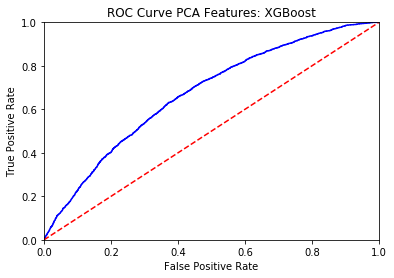

In [285]:
fpr, tpr, threshold = roc_curve(y_rf_test, xgb_test_prob)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve PCA Features: XGBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [350]:
xgb_final = classification_report(y_rf_test,test_preds,output_dict=True)
report_xgb_final = pd.DataFrame(xgb_final).transpose()
report_xgb_final

,precision,recall,f1-score,support
0,0.941782,0.640715,0.762610,19138.000000
1,0.148483,0.612672,0.239035,1957.000000
accuracy,0.638113,0.638113,0.638113,0.638113
macro avg,0.545132,0.626694,0.500822,21095.000000
weighted avg,0.868187,0.638113,0.714037,21095.000000


In [351]:
confusion_matrix(y_rf_test,test_preds)

array([[12262,  6876],
       [  758,  1199]], dtype=int64)

### SMOTE: Under-sampling

In [125]:
#function to plot roc curve
def plot_roc(y_test,y_pred,title):
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [127]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced, sensitivity_score, specificity_score

In [80]:
model = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('sampling', RandomUnderSampler(sampling_strategy=0.5)),
        ('classification', XGBClassifier(objective='binary:logistic'))])

In [81]:
param_grid_xgb = [
    {'classification__n_estimators': [50,100,150,200],
     'classification__learning_rate': [0.01,0.1,0.2,0.3],
     'classification__max_depth': range(3,10),
     'classification__colsample_bytree': [i/10 for i in range(1,3)],
     'classification__gamma': [i/10 for i in range(3)],
     'classification__scale_pos_weight': [8,9,10],
     'classification__reg_alpha': [1,5,10,15,20],
     'classification__reg_lambda':[1,5,10,15,20]
    }]

In [82]:
# create a random_search of the pipeline, to find optimal the best model
random_search = RandomizedSearchCV(model, 
                                   param_distributions = param_grid_xgb, 
                                   cv=5, 
                                   verbose=0,
                                   n_jobs=-1,
                                   n_iter=10,
                                   scoring='roc_auc')

In [83]:
%%time
# Fit random search object
smote_model = random_search.fit(X_rf_train,y_rf_train)
# output best more and PR AUC score
print(smote_model.best_estimator_)
print("The AUC score of the model is:",smote_model.score(X_rf_test,y_rf_test))

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampling', RandomUnderSampler(sampling_strategy=0.5)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.2, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=5, reg_lambda=20, scale_pos_weight=10,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbo

In [84]:
test_predz = smote_model.predict_proba(X_rf_test)
smote_test_prob = test_predz[:,1]

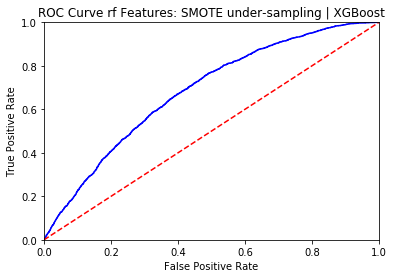

In [126]:
plot_roc(y_rf_test,smote_test_over_prob,'ROC Curve rf Features: SMOTE under-sampling | XGBoost')

In [86]:
test_predz_smote = smote_model.predict(X_rf_test)
train_predz_smote = smote_model.predict(X_rf_train)

In [87]:
confusion_matrix(y_rf_test,test_predz_smote)

array([[ 3637, 15501],
       [   67,  1890]], dtype=int64)

In [88]:
print(roc_auc_score(y_rf_train,train_predz_smote))
print(roc_auc_score(y_rf_test,test_predz_smote))

0.5971301242921858
0.577902340491964


In [90]:
smote_final = classification_report(y_rf_test,test_predz_smote,output_dict=True)
report_smote_final = pd.DataFrame(smote_final).transpose()
report_smote_final

,precision,recall,f1-score,support
0,0.981911,0.190041,0.318448,19138.000000
1,0.108677,0.965764,0.195369,1957.000000
accuracy,0.262005,0.262005,0.262005,0.262005
macro avg,0.545294,0.577902,0.256909,21095.000000
weighted avg,0.900901,0.262005,0.307030,21095.000000


In [79]:
#precision is low due to high fp rate, and recall is high due to low false positive rate

In [92]:
sensitivity_score(y_rf_test,test_predz_smote)

0.9657639243740419

In [93]:
specificity_score(y_rf_test,test_predz_smote)

0.1900407566098861

### SMOTE: Over-sampling

In [95]:
model_over = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('sampling', SMOTE(sampling_strategy=0.5)),
        ('classification', XGBClassifier(objective='binary:logistic'))])

In [97]:
# create a random_search of the pipeline, to find optimal the best model
random_search = RandomizedSearchCV(model_over, 
                                   param_distributions = param_grid_xgb, 
                                   cv=5, 
                                   verbose=0,
                                   n_jobs=-1,
                                   n_iter=10,
                                   scoring='roc_auc')

In [99]:
%%time
# Fit random search object
smote_model_over = random_search.fit(X_rf_train,y_rf_train)
# output best more and PR AUC score
print(smote_model_over.best_estimator_)
print("The AUC score of the model is:",smote_model_over.score(X_rf_test,y_rf_test))

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampling', SMOTE(sampling_strategy=0.5)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.2, gamma=0.0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=1, reg_lambda=1, scale_pos_weight=10,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])


In [113]:
test_predz_over = smote_model_over.predict_proba(X_rf_test)
smote_test_over_prob = test_predz_over[:,1]

In [123]:
def plot_roc(y_test,y_pred,title):
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

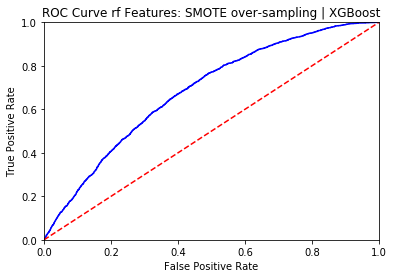

In [124]:
plot_roc(y_rf_test,smote_test_over_prob,'ROC Curve rf Features: SMOTE over-sampling | XGBoost')

In [105]:
test_predz_smote_over = smote_model_over.predict(X_rf_test)
train_predz_smote_over = smote_model_over.predict(X_rf_train)

In [106]:
confusion_matrix(y_rf_test,test_predz_smote_over)

array([[10550,  8588],
       [  547,  1410]], dtype=int64)

In [107]:
print(roc_auc_score(y_rf_train,train_predz_smote_over))
print(roc_auc_score(y_rf_test,test_predz_smote_over))

0.6777742249244383
0.6358749107482949


In [108]:
smote_final = classification_report(y_rf_test,test_predz_smote_over,output_dict=True)
report_smote_final = pd.DataFrame(smote_final).transpose()
report_smote_final

,precision,recall,f1-score,support
0,0.950707,0.551259,0.697867,19138.000000
1,0.141028,0.720491,0.235885,1957.000000
accuracy,0.566959,0.566959,0.566959,0.566959
macro avg,0.545868,0.635875,0.466876,21095.000000
weighted avg,0.875593,0.566959,0.655008,21095.000000


In [110]:
sensitivity_score(y_rf_test,test_predz_smote_over)

0.7204905467552376

In [112]:
specificity_score(y_rf_test,test_predz_smote_over)

0.5512592747413523